# Ex 2 - Transfer learning
##### Group: X
###### Student 1: Dennis Shushack
###### Student 2: 
###### Student 3: 

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds  # first: pip install tensorflow_datasets

from sklearn.metrics import accuracy_score

/Users/nnann/anaconda3/envs/tf_cpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Dataset and visualize it

In [2]:
# Download and split the food101 dataset
(train_ds, validation_ds, test_ds), info = tfds.load(
    "food101",
    split=["train", "validation[:50%]", "validation[50%:]"],
    as_supervised=True,
    with_info=True
)

In [3]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20
CLASS_NAMES = info.features['label'].names[:N_CLASSES]

train_ds = train_ds.filter(lambda img, label: label < N_CLASSES)
validation_ds = validation_ds.filter(lambda img, label: label < N_CLASSES)
test_ds = test_ds.filter(lambda img, label: label < N_CLASSES)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
# See if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [5]:
# This step takes too much time. It is not madatory to execute it.
print("Training samples: %d" % train_ds.reduce(0, lambda x,_: x+1).numpy())
print("Validation samples: %d" % validation_ds.reduce(0, lambda x,_: x+1).numpy())
print("Tests samples: %d" % test_ds.reduce(0, lambda x,_: x+1).numpy())

2023-05-24 09:55:43.020402: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training samples: 15000
Validation samples: 2514
Tests samples: 2486


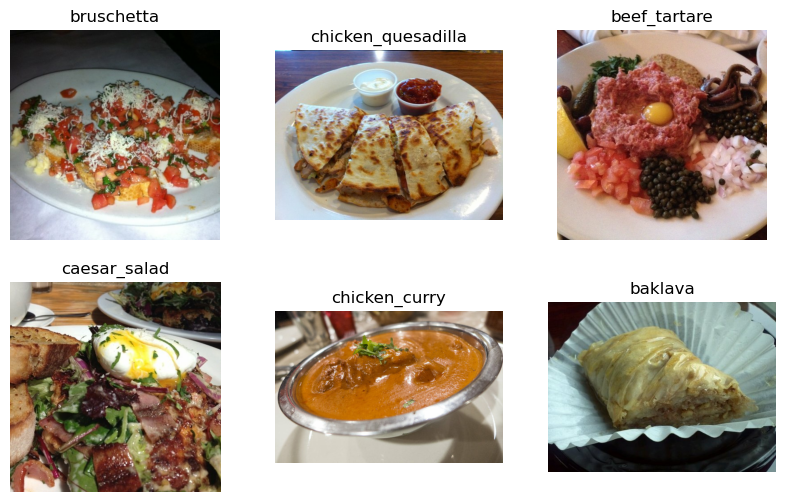

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for i, (image, label) in enumerate(train_ds.take(6)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

## Resize and normalize

In [7]:
# Check sizes
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (512, 512, 3)


In [8]:
# TODO Resize the images in the training, validation and test set
IMG_SIZE = (224, 224) 

def resize_images(img, label):
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

train_ds = train_ds.map(resize_images)
validation_ds = validation_ds.map(resize_images)
test_ds = test_ds.map(resize_images)


In [9]:
# Normalize the images
train_ds = train_ds.map(lambda img, label: (img / 255.0, label))
validation_ds = validation_ds.map(lambda img, label: (img / 255.0, label))
test_ds = test_ds.map(lambda img, label: (img / 255.0, label))

In [10]:
# Check if the size is correct and the scaling is done
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print(image.numpy().min(), image.numpy().max())

Image shape:  (224, 224, 3)
0.0 1.0


In [11]:
# One hot encode the labels
train_ds = train_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
validation_ds = validation_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))
test_ds = test_ds.map(lambda img, label: (img, tf.one_hot(label, N_CLASSES)))

# Check if the labels are correctly encoded
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print(image.numpy().min(), image.numpy().max())
    print("Label: ", label.numpy())

BATCH_SIZE = 64

train_ds = train_ds.cache()
validation_ds = validation_ds.cache()
test_ds = test_ds.cache()

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

Image shape:  (224, 224, 3)
0.0 1.0
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Data-Augmentation

In [12]:
# Optional define/implements data-augmentation
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),
     layers.RandomFlip()]
)

## Training
### Step 1: Only train the head of the network

In [13]:
%%time
# Load the pretrained model from the available models: https://keras.io/api/applications/#available-models. 
# Load the imagenet weights but do not include the ImageNet classifier at the top.
#
# Tip, don't choose models that are too big because the training could take hours. 
# A model like mobilenet is more than enough for the exercise.

imgsize = (224, 224, 3)

base_model = tf.keras.applications.ResNet50V2(
    include_top=False,  # Do not include the ImageNet classifier at the top.
    weights="imagenet",
    input_shape=imgsize
)

# Freeze the base_model
base_model.trainable = False

# Create the model structure
inputs = keras.Input(shape=imgsize)
x = data_augmentation(inputs)

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)  
x = tf.keras.layers.Dense(1024, activation='relu')(x)  
x = tf.keras.layers.Dropout(0.5)(x)  
outputs = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(x) 

model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 12s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                             

In [14]:
%%time


# Compile the model with your optimizer, your loss and your metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Optional: Define and use callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

step1_history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=20, 
    callbacks=[early_stopping],
)# You should us a relatively big learning rate: 1e-3

Epoch 1/20
235/235 [==============================] - 374s 2s/step - loss: 1.7036 - accuracy: 0.5000 - val_loss: 1.1979 - val_accuracy: 0.6257
Epoch 2/20
235/235 [==============================] - 372s 2s/step - loss: 1.2423 - accuracy: 0.6211 - val_loss: 1.0756 - val_accuracy: 0.6698
Epoch 3/20
235/235 [==============================] - 356s 2s/step - loss: 1.0710 - accuracy: 0.6695 - val_loss: 1.0438 - val_accuracy: 0.6730
Epoch 4/20
235/235 [==============================] - 394s 2s/step - loss: 0.9436 - accuracy: 0.7047 - val_loss: 1.0288 - val_accuracy: 0.6862
Epoch 5/20
235/235 [==============================] - 391s 2s/step - loss: 0.8449 - accuracy: 0.7327 - val_loss: 1.0190 - val_accuracy: 0.6806
Epoch 6/20
235/235 [==============================] - 381s 2s/step - loss: 0.7393 - accuracy: 0.7599 - val_loss: 1.0517 - val_accuracy: 0.6893
Epoch 7/20
235/235 [==============================] - 360s 2s/step - loss: 0.6520 - accuracy: 0.7872 - val_loss: 1.0559 - val_accuracy: 0.6889

KeyboardInterrupt: 

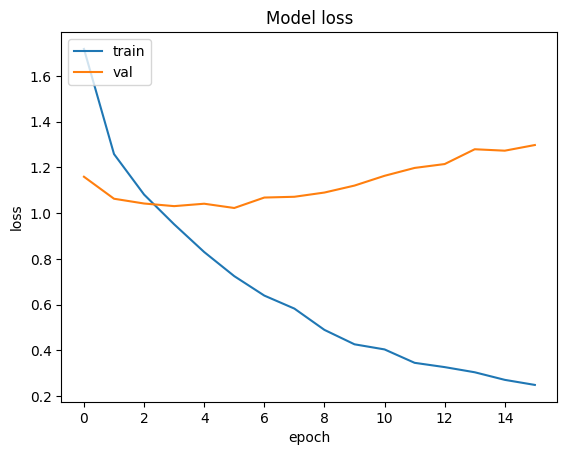

In [ ]:
def plot_history(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(step1_history, 'loss')

### Step 2: Fine-Tune the whole model

In [ ]:
# Show all gpu devices with tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6246561645078080410
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14881783808
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 8959449813650627828
physical_device_desc: "device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:19:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14884667392
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 13964410343294605953
physical_device_desc: "device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:53:00.0, compute capability: 8.6"
xla_global_id: 2144165316
]


2023-05-22 20:09:33.900572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 14192 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-05-22 20:09:33.900838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:1 with 14195 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:53:00.0, compute capability: 8.6


In [ ]:
%%time

# Unfreeze the pretrained base. 
base_model.trainable = True
model.summary()

# Compile the model again
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
epochs = 20
# Retrain the model
step2_history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs, callbacks=[early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                             

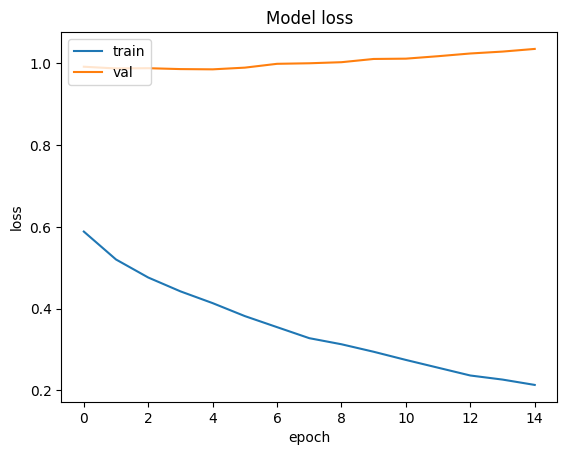

In [ ]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [ ]:
%%time
# Predict the test set
y_pred = model.predict(test_ds, verbose=1)

# De-encode the onehot encoded labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds], axis=0)

2023-05-22 20:31:39.190191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8]
	 [[{{node Placeholder/_1}}]]
2023-05-22 20:31:39.191555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]


39/39 [==============================] - 4s 84ms/step
CPU times: user 49.8 s, sys: 3.93 s, total: 53.8 s
Wall time: 4.29 s


In [ ]:
%%time

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.7139983909895414
CPU times: user 4.21 ms, sys: 6 µs, total: 4.22 ms
Wall time: 3.23 ms


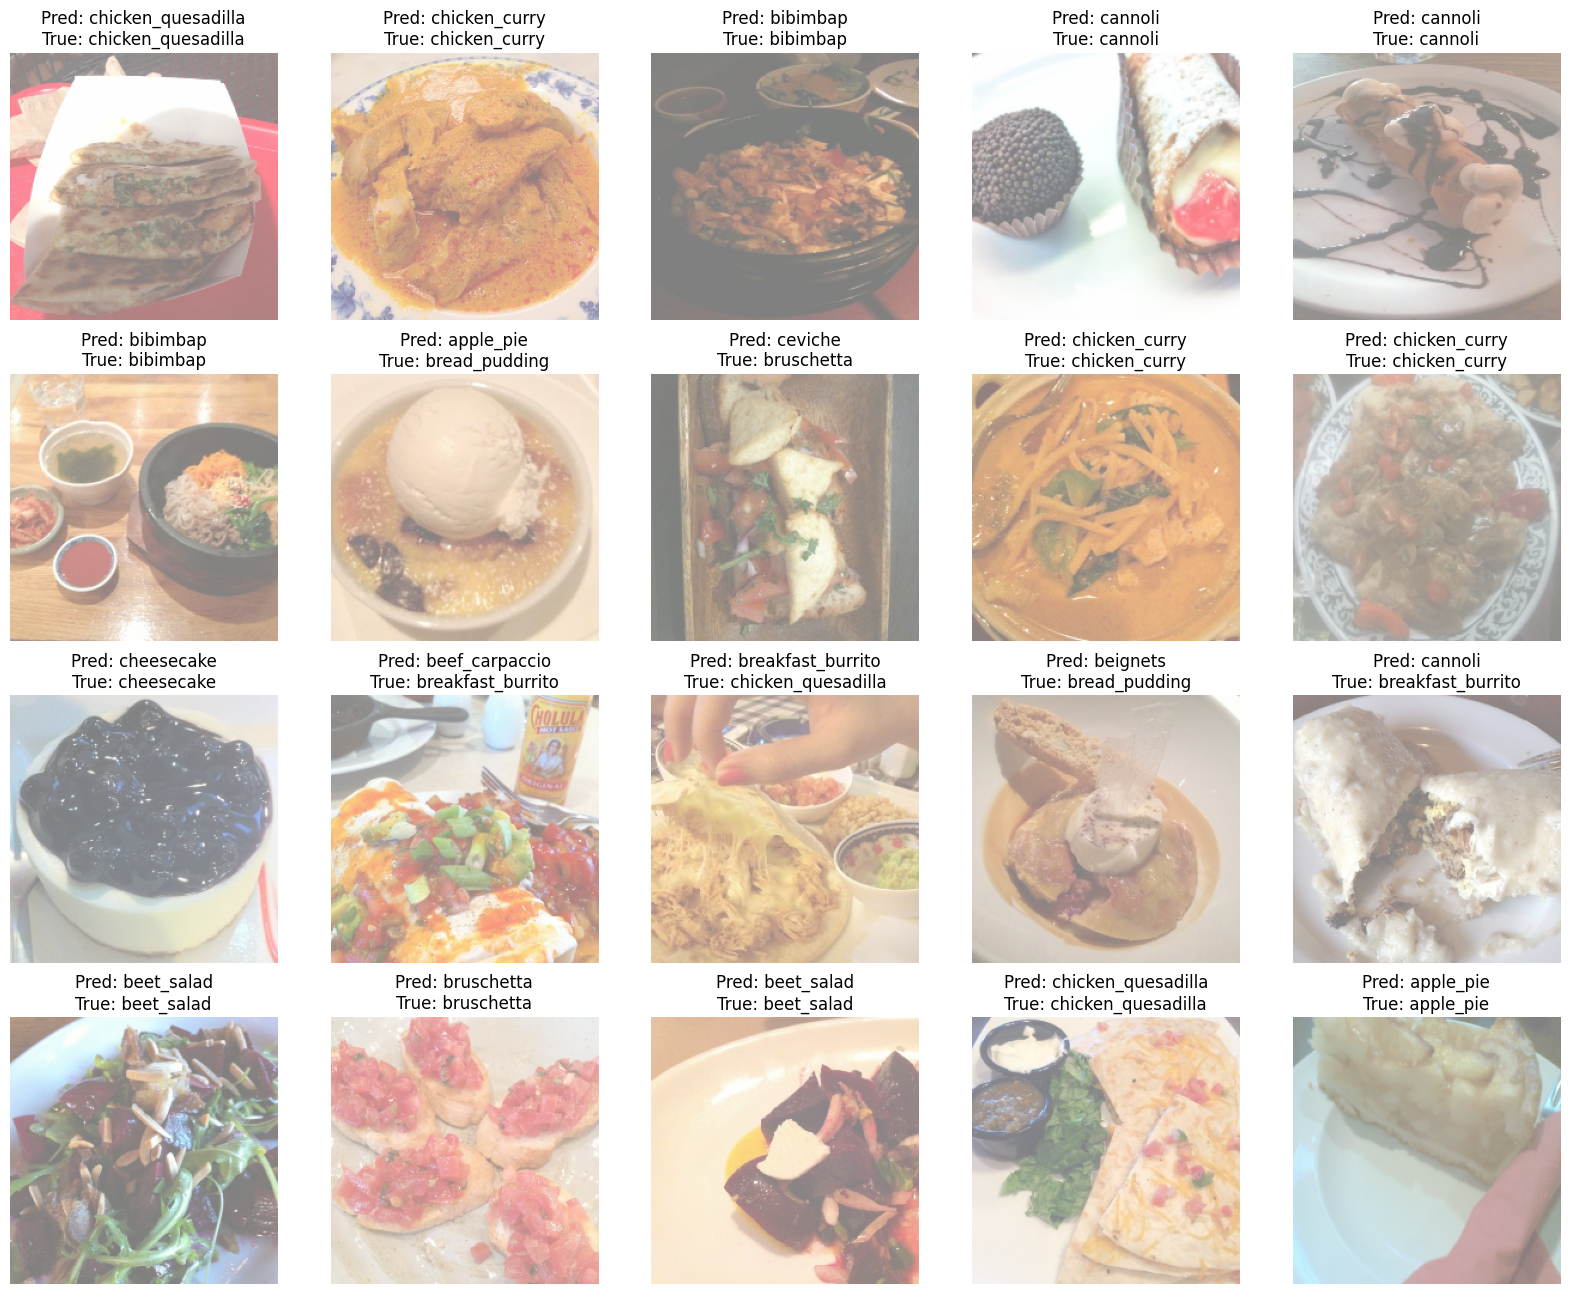

In [ ]:
def show_images_prediction(page=0):
    test_examples = (np.concatenate([x.numpy() for x, y in test_ds])+1)/2*255
    test_examples = test_examples.astype("uint32")
    
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(20, 16)

    start_i = page * page_size
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(test_examples[i+start_i])
        ax.set_axis_off()
        ax.set_title("Pred: "+CLASS_NAMES[y_pred[i+start_i]]+"\nTrue: "+CLASS_NAMES[y_true[i+start_i]])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

    plt.show()
show_images_prediction(2)